100%|██████████| 10001/10001 [00:01<00:00, 8224.89it/s]


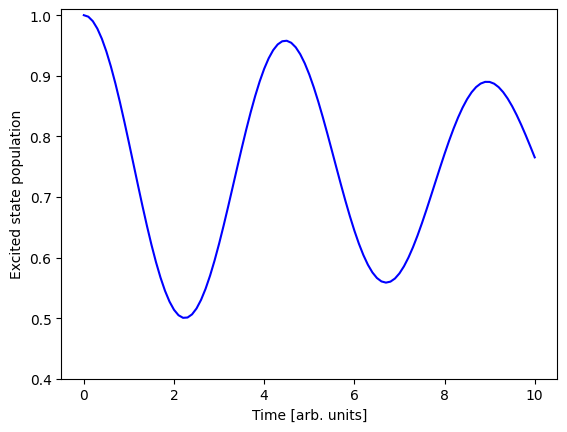

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qclab import Simulation
from qclab.models import SpinBoson
from qclab.algorithms import MeanField
from qclab.dynamics import serial_driver

# Initialize the simulation object.
sim = Simulation()
# Equip it with a spin-boson model object.
sim.model = SpinBoson()
# Attach the mean-field algorithm.
sim.algorithm = MeanField()
# Initialize the diabatic wavevector.
# Here, the first vector element refers to the upper state and the second
# element refers to the lower state.
sim.initial_state["wf_db"] = np.array([1, 0], dtype=complex)

# Run the simulation.
data = serial_driver(sim)
# Pull out the time.
t = data.data_dict["t"]
# Get populations from the diagonal of the density matrix.
populations = np.real(np.einsum("tii->ti", data.data_dict["dm_db"]))
plt.plot(t, populations[:, 0], color="blue")
plt.xlabel('Time [arb. units]')
plt.ylabel('Excited state population')
plt.ylim([0.4,1.01])
plt.show()

100%|██████████| 10001/10001 [00:01<00:00, 7673.01it/s]


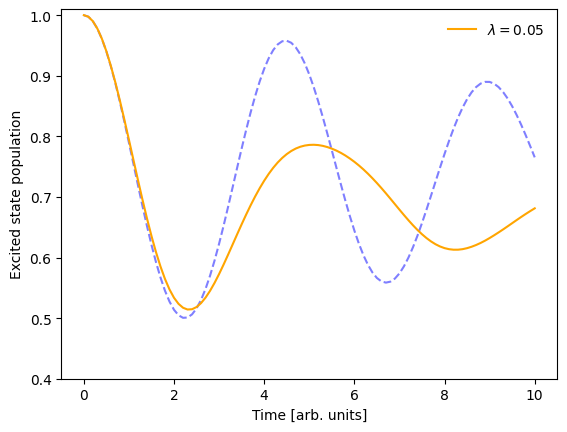

In [2]:
sim.model.constants.l_reorg = 0.05

# Run the simulation.
data1 = serial_driver(sim)
# Pull out the time.
t1 = data1.data_dict["t"]
# Get populations from the diagonal of the density matrix.
populations1 = np.real(np.einsum("tii->ti", data1.data_dict["dm_db"]))
plt.plot(t, populations[:, 0], color="blue", alpha=0.5,linestyle='dashed')
plt.plot(t1, populations1[:, 0], color="orange",label=r"$\lambda=0.05$")
plt.xlabel('Time [arb. units]')
plt.ylabel('Excited state population')
plt.ylim([0.4,1.01])
plt.legend(frameon=False)
plt.show()

100%|██████████| 10001/10001 [00:03<00:00, 2866.40it/s]


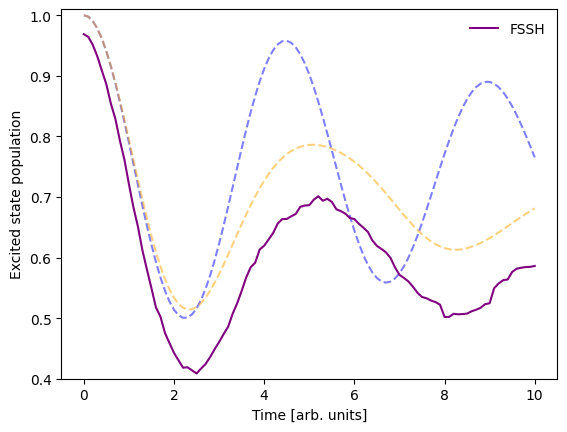

In [3]:
from qclab.algorithms import FewestSwitchesSurfaceHopping

sim.algorithm = FewestSwitchesSurfaceHopping()
# Run the simulation.
data2 = serial_driver(sim)
# Pull out the time.
t2 = data2.data_dict["t"]
# Get populations from the diagonal of the density matrix.
populations2 = np.real(np.einsum("tii->ti", data2.data_dict["dm_db"]))
plt.plot(t, populations[:, 0], color="blue", alpha=0.5,linestyle='dashed')
plt.plot(t1, populations1[:, 0], color="orange",alpha=0.5,linestyle='dashed')
plt.plot(t2, populations2[:, 0], color="purple",label="FSSH")
plt.xlabel('Time [arb. units]')
plt.ylabel('Excited state population')
plt.ylim([0.4,1.01])
plt.legend(frameon=False)
plt.show()

100%|██████████| 10001/10001 [00:03<00:00, 2556.39it/s]


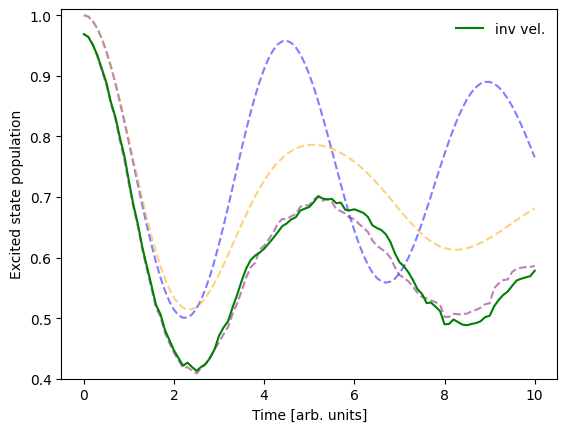

In [4]:
def update_z_reverse_frustrated_fssh(sim, state, parameters):
    """
    Reverse the velocities of frustrated trajectories in the FSSH algorithm.
    """
    # Get the indices of trajectories that were frustrated
    # (i.e., did not successfully hop but were eligible to hop).
    frustrated_indices = state["hop_ind"][~state["hop_successful"]]
    # Reverse the velocities for these indices, in the complex classical coordinate
    # formalism, this means conjugating the z coordinate.
    state["z"][frustrated_indices] = state["z"][frustrated_indices].conj()
    return state, parameters

sim.algorithm.update_recipe.append(update_z_reverse_frustrated_fssh)

data3 = serial_driver(sim)
# Pull out the time.
t3 = data3.data_dict["t"]
# Get populations from the diagonal of the density matrix.
populations3 = np.real(np.einsum("tii->ti", data3.data_dict["dm_db"]))
plt.plot(t, populations[:, 0], color="blue", alpha=0.5,linestyle='dashed')
plt.plot(t1, populations1[:, 0], color="orange",alpha=0.5,linestyle='dashed')
plt.plot(t2, populations2[:, 0], color="purple",alpha=0.5,linestyle='dashed')
plt.plot(t3, populations3[:, 0], color="green",label="inv vel.")
plt.xlabel('Time [arb. units]')
plt.ylabel('Excited state population')
plt.ylim([0.4,1.01])
plt.legend(frameon=False)
plt.show()

100%|██████████| 10001/10001 [00:07<00:00, 1286.52it/s]


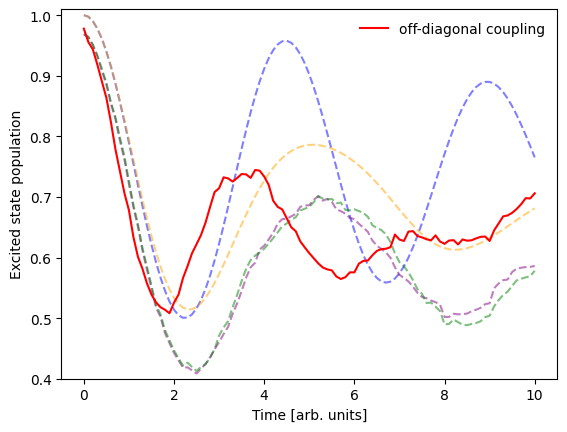

In [7]:
from qclab.functions import vectorize_ingredient

@vectorize_ingredient
def h_qc(model, parameters, **kwargs):
    """
    A coupling term that couples the boson coordinates to the off-diagonal elements of the quantum Hamiltonian.
    """
    # First we'll get the z coordinate from the keyword arguments
    z = kwargs['z']
    # Next we'll get the Required constants from the constants object.
    m = model.constants.classical_coordinate_mass
    h = model.constants.classical_coordinate_weight
    g = model.constants.harmonic_frequency * np.sqrt(2 * model.constants.l_reorg / model.constants.A)
    # Now we can construct the empty Hamiltonian matrix as a 2x2 complex array.
    h_qc = np.zeros((2, 2), dtype=complex)
    # Then we can populate the off-diagonal elements of the Hamiltonian matrix.
    h_qc[0, 1] = np.sum((g * np.sqrt(1 / (2 * m * h))) * (z + np.conj(z)))
    h_qc[1, 0] = np.conj(h_qc[0, 1])
    return h_qc

# Add the new coupling term to the model's ingredients.
sim.model.ingredients.append(("h_qc", h_qc))
# Overwrite the analytical gradient ingredient, which is no longer correct for the new coupling.
sim.model.ingredients.append(("dh_qc_dzc", None))

data4 = serial_driver(sim)
# Pull out the time.
t4 = data4.data_dict["t"]
# Get populations from the diagonal of the density matrix.
populations4 = np.real(np.einsum("tii->ti", data4.data_dict["dm_db"]))
plt.plot(t, populations[:, 0], color="blue", alpha=0.5,linestyle='dashed')
plt.plot(t1, populations1[:, 0], color="orange",alpha=0.5,linestyle='dashed')
plt.plot(t2, populations2[:, 0], color="purple",alpha=0.5,linestyle='dashed')
plt.plot(t3, populations3[:, 0], color="green",alpha=0.5,linestyle='dashed')
plt.plot(t4, populations4[:, 0], color="red",label="off-diagonal coupling")
plt.xlabel('Time [arb. units]')
plt.ylabel('Excited state population')
plt.ylim([0.4,1.01])
plt.legend(frameon=False)
plt.show()

100%|██████████| 10001/10001 [00:07<00:00, 1347.57it/s]
/tmp/ipykernel_92812/1413349673.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


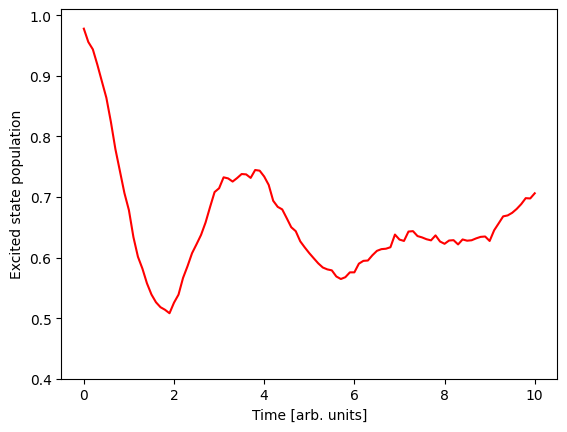

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from qclab import Simulation
from qclab.models import SpinBoson
from qclab.algorithms import FewestSwitchesSurfaceHopping
from qclab.dynamics import serial_driver
from qclab.functions import vectorize_ingredient

def update_z_reverse_frustrated_fssh(sim, state, parameters):
    """
    Reverse the velocities of frustrated trajectories in the FSSH algorithm.
    """
    # Get the indices of trajectories that were frustrated
    # (i.e., did not successfully hop but were eligible to hop).
    frustrated_indices = state["hop_ind"][~state["hop_successful"]]
    # Reverse the velocities for these indices, in the complex classical coordinate
    # formalism, this means conjugating the z coordinate.
    state["z"][frustrated_indices] = state["z"][frustrated_indices].conj()
    return state, parameters

@vectorize_ingredient
def h_qc(model, parameters, **kwargs):
    """
    A coupling term that couples the boson coordinates to the off-diagonal elements of the quantum Hamiltonian.
    """
    # First we'll get the z coordinate from the keyword arguments
    z = kwargs['z']
    # Next we'll get the Required constants from the constants object.
    m = model.constants.classical_coordinate_mass
    h = model.constants.classical_coordinate_weight
    g = model.constants.harmonic_frequency * np.sqrt(2 * model.constants.l_reorg / model.constants.A)
    # Now we can construct the empty Hamiltonian matrix as a 2x2 complex array.
    h_qc = np.zeros((2, 2), dtype=complex)
    # Then we can populate the off-diagonal elements of the Hamiltonian matrix.
    h_qc[0, 1] = np.sum((g * np.sqrt(1 / (2 * m * h))) * (z + np.conj(z)))
    h_qc[1, 0] = np.conj(h_qc[0, 1])
    return h_qc

# Initialize the simulation object.
sim = Simulation()
# Equip it with a spin-boson model object.
sim.model = SpinBoson()
# Change the reorganization energy.
sim.model.constants.l_reorg = 0.05
# Add the new coupling term to the model's ingredients.
sim.model.ingredients.append(("h_qc", h_qc))
# Overwrite the analytical gradient ingredient, which is no longer correct for the new coupling.
sim.model.ingredients.append(("dh_qc_dzc", None))
# Attach the FSSH algorithm.
sim.algorithm = FewestSwitchesSurfaceHopping()
# Insert the function for reversing velocities as a task into the update recipe.
sim.algorithm.update_recipe.append(update_z_reverse_frustrated_fssh)
# Initialize the diabatic wavevector. 
# Here, the first vector element refers to the upper state and the second
# element refers to the lower state.
sim.initial_state["wf_db"] = np.array([1, 0], dtype=complex)

# Run the simulation.
data = serial_driver(sim)

# Pull out the time.
t = data.data_dict["t"]
# Get populations from the diagonal of the density matrix.
populations = np.real(np.einsum("tii->ti", data.data_dict["dm_db"]))
plt.plot(t, populations[:, 0], color="red")
plt.xlabel('Time [arb. units]')
plt.ylabel('Excited state population')
plt.ylim([0.4,1.01])
plt.legend(frameon=False)
plt.show()